In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker

In [2]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """
    # Initialize columns if None
    if columns is None:
        columns = []

    # Base columns to always include
    base_columns = ['sys/tags', 'sys/id', 'args/cutoff', 'args/batch_size', 'loss']
    columns.extend(base_columns)

    # Mapping for 'start' and 'end' arguments
    prefix_mapping = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }

    # Components to include in the arguments columns
    components = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']

    # Build columns for each combination of 'start/end' and components
    for position in ['start', 'end']:
        for component in components:
            prefix = prefix_mapping[position]
            column_name = f'args/{prefix}/{component}'
            columns.append(column_name)

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(
        tag=tags,
        columns=columns
    ).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    runs_table['sys/tags'] = runs_table['sys/tags'].apply(
        lambda x: x.split(',') if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table['sys/tags'].apply(lambda x: neg_tag in x)
            ]

    print(f'Table downloaded\nShape: {runs_table.shape}')
    return runs_table


https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (25, 8)
[[5.338125, 10.0, 2.0], [5.3253125, 10.0, 1.0], [5.365, 20.0, 2.0], [5.3390625, 20.0, 1.0], [5.3275, 20.0, 0.5], [5.316875, 20.0, 0.2], [5.311875, 20.0, 0.1], [5.331875, 5.0, 2.0], [5.3209375, 5.0, 1.0], [5.3178125, 10.0, 0.2], [5.3125, 2.0, 0.2], [5.305625, 10.0, 0.1], [5.3046875, 2.0, 1.0], [5.314375, 2.0, 2.0], [5.3084375, 2.0, 0.5], [5.31625, 10.0, 0.5], [5.3203125, 2.0, 0.1], [5.3115625, 5.0, 0.2], [5.3025, 5.0, 0.5], [5.3109375, 1.0, 1.0], [5.3065625, 1.0, 2.0], [5.3140625, 5.0, 0.1], [5.3175, 1.0, 0.2], [5.3075, 1.0, 0.5], [5.325, 1.0, 0.1]]
[[ 5.338125  10.         2.       ]
 [ 5.3253125 10.         1.       ]
 [ 5.365     20.         2.       ]
 [ 5.3390625 20.         1.       ]
 [ 5.3275    20.         0.5      ]
 [ 5.316875  20.         0.2      ]
 [ 5.311875  20.         0.1      ]
 [ 5.331875   5.         2.       ]
 [ 5.3209375  5.         1.       ]
 [ 5.3178125 10.         0.2      ]
 [ 5.3125  

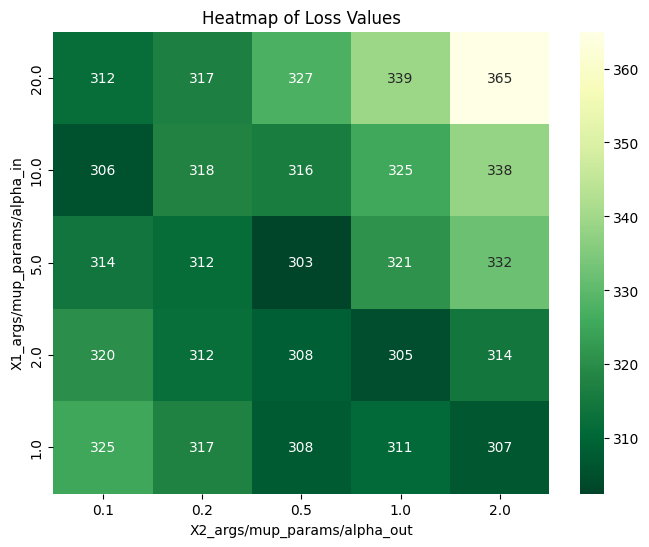

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

LOSS_COL = "loss_interval/100"
X1_COL = "args/mup_params/alpha_in"
X2_COL = "args/mup_params/alpha_out"
runs = get_neptune_table(["alpha_grid", "muP_MoE"], columns=[X1_COL, X2_COL, LOSS_COL])

data = runs[[LOSS_COL, X1_COL, X2_COL]].to_dict("tight")["data"]
print(data)
data = np.array(data)
print(data)

loss = data[:, 0]
best_biased = loss.min()
# loss = (loss - loss.min()) / (loss.max() - loss.min())
loss = loss - np.floor(loss)
loss = loss * 1000
data[:, 0] = loss


# Extract x1, x2, and loss
x1_values = sorted(set([x1 for _, x1, _ in data]), reverse=True)
x2_values = sorted(set([x2 for _, _, x2 in data]))
# Create a 2D grid for loss values
loss_grid = np.full((len(x1_values), len(x2_values)), np.nan)

# Fill the grid with loss values
for loss, x1, x2 in data:
    i = x1_values.index(x1)
    j = x2_values.index(x2)
    loss_grid[i, j] = loss

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_grid, annot=True, xticklabels=x2_values, yticklabels=x1_values, cmap='YlGn_r', fmt=".0f")
plt.xlabel(f'X2_{X2_COL}')
plt.ylabel(f'X1_{X1_COL}')
plt.title('Heatmap of Loss Values')
plt.show()

In [9]:
def calculate_from_args_model_parameter_counts(dmodel, cutoff, vocab_size, isgated, dff, active_ratio, ismoe, n_experts, n_blocks):
    embedding_parameters = vocab_size * dmodel + cutoff * dmodel
    head_parameters = vocab_size * dmodel

    layer_norm_params = 2 * dmodel

    attention_params = (dmodel**2) * 4  # Q, K, V and O projections

    if isgated:
        ff_total_params = 3 * dmodel * dff
    else:
        ff_total_params = 2 * dmodel * dff

    ff_active_params = (
        ff_total_params * active_ratio
    )  # when not MoE, active_ratio = 1

    print(f"experts active/total: {ff_active_params}/{ff_total_params}")

    router_params = 0
    if ismoe:
        router_params = dmodel * n_experts
        print(f"router: {router_params}")

    n_blocks = n_blocks
    all_layer_norm_params = (
        n_blocks * layer_norm_params * 2
    )  # 2 because LN in attention and LN in FF
    all_attention_params = n_blocks * attention_params
    all_ff_total_params = n_blocks * ff_total_params
    all_ff_active_params = n_blocks * ff_active_params
    all_router_params = n_blocks * router_params

    return (
        embedding_parameters,
        all_layer_norm_params,
        all_attention_params,
        all_ff_total_params,
        all_ff_active_params,
        all_router_params,
        head_parameters,
    )

dmodel = 4096
isgated = True
dff = 3.5 * dmodel
ismoe = False
vocab_size = 50000
active_ratio = 1.0
n_experts = None
cutoff = 512
n_blocks = 32

print(f'w/d:\t{dmodel / n_blocks:.2f}')

(
    embedding_parameters,
    all_layer_norm_params,
    all_attention_params,
    all_ff_total_params,
    all_ff_active_params,
    all_router_params,
    head_parameters,
) = calculate_from_args_model_parameter_counts(dmodel, cutoff, vocab_size, isgated, dff, active_ratio, ismoe, n_experts, n_blocks)

tower_params = all_layer_norm_params + all_attention_params + all_ff_total_params

print(f'model params:\t{tower_params / 1e9:.2f} billion')


w/d:	128.00
experts active/total: 176160768.0/176160768.0
model params:	7.79 billion


In [59]:
fineweb_tokens = 1.3e12
token_to_param = fineweb_tokens / tower_params

print(f'token/param:\t{token_to_param:.2f}')

token/param:	166.98


In [60]:
def hours(mfu, params, tokens, flops_per_s=990):
    flopsy = 6 * params * tokens
    operations_per_s = flops_per_s * mfu * 1e12
    training_s = flopsy / operations_per_s
    training_h = training_s / 3600
    return training_h

mfu = 0.2
params = tower_params
# params = 2.5 * 1e9
tokens = 20 * params
print(f'tokens: {tokens / 1e9:.2f}B')
h = hours(mfu, params, tokens)
print(f'training will take: {h:.0f} h')
num_nodes = 0.35
print(f'using {num_nodes} nodes this will take: {h / (num_nodes * 4 * 24):.0f} d')
hour_cost = 3
print(f'total cost: {h * hour_cost:.0f}$')
print(f'total cost: {h * hour_cost * 4.08:.0f}zł')


tokens: 155.70B
training will take: 10203 h
using 0.35 nodes this will take: 304 d
total cost: 30610$
total cost: 124890zł
